In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-detection-preprocess/Test_set.csv
/kaggle/input/spam-detection-preprocess/Train_set.csv


## Import Libraries:

In [2]:
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from kmodes.kmodes import KModes
from wordcloud import WordCloud
import string

import warnings
warnings.filterwarnings("ignore")



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

#Load spaCy model
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read train Data:

In [4]:
train_data=pd.read_csv("/kaggle/input/spam-detection-preprocess/Train_set.csv")
train_data.head()

,Unnamed: 0,id,Body,Label
0,4006,83044,"Subject: new jcc stuff vince , i ' m gone thr...",0.0
1,6645,36465,Subject: = ? iso - 8859 - 1 ? q ? automaattine...,1.0
2,13662,30041,Subject: we need your help\n dear southtrust c...,1.0
3,7706,72756,bank accountdoctyp html public wnumbercdtd htm...,1.0
4,10855,54804,Subject: dinner speaker - may 23\n vince :\n m...,0.0


In [5]:
test_data=pd.read_csv("/kaggle/input/spam-detection-preprocess/Test_set.csv")
test_data.head()

,Unnamed: 0,id,Body
0,4934,22406,Subject: i ' m a changed man\n dear sir / mada...
1,8832,19495,Subject: = ? iso - 8859 - 1 ? q ? win _ notice...
2,11742,59875,Subject: ngx - enron - security in place .\n h...
3,1514,40297,Subject: sitara availability\n as a precaution...
4,4431,50696,Subject: inception document for gtv ii phase i...


In [6]:
# value_counts of the label:

train_data.Label.value_counts()

0.0    8400
1.0    4753
Name: Label, dtype: int64

## Creating a Word Cloud for Non-Spam Emails (before preprocess):

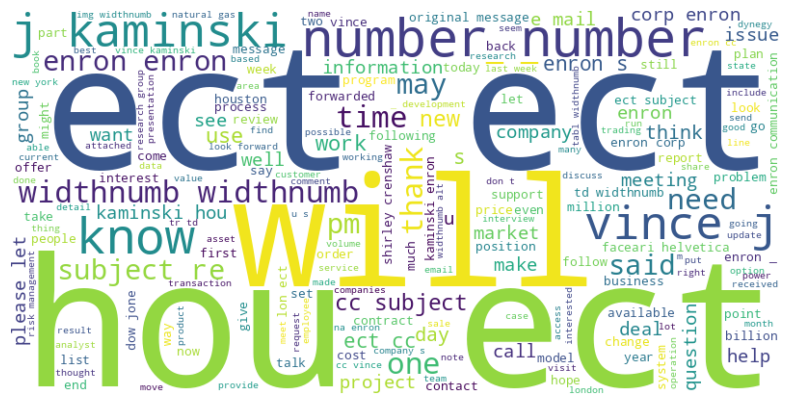

In [7]:
# Train world cloud for non-spam:

wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(train_data[train_data['Label'] == 0]['Body']))
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

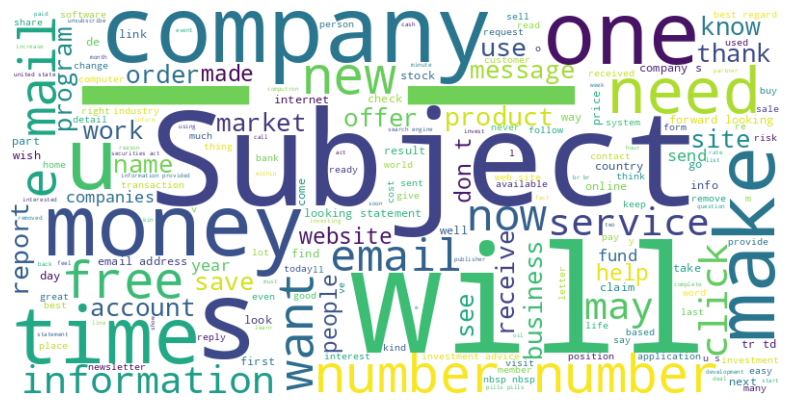

In [8]:
# Train world cloud for spam:

wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(train_data[train_data['Label'] == 1]['Body']))
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

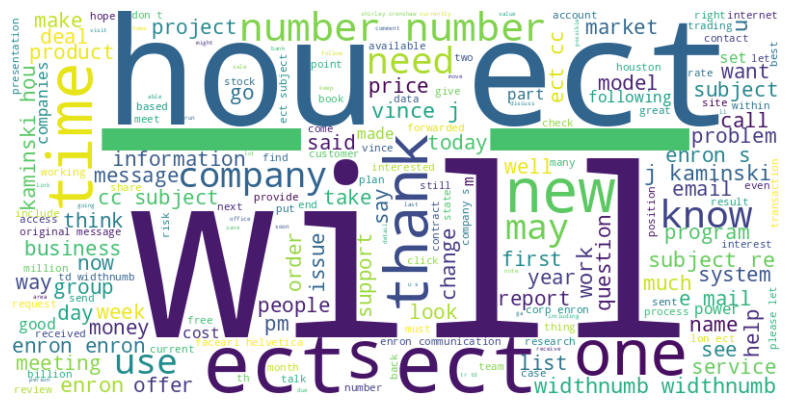

In [9]:
# Test world cloud:

wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(test_data['Body']))
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Data cleaning before feature extraction:


In [10]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))

    # Tokenize the text using spaCy and apply lemmatization
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]

    words = [word for word in lemmatized_words if not word.lower().startswith("subject")]
    words = [word for word in words if word.lower() != "re" and word.lower() != "'re"]
    words = [word for word in words if not word.lower().startswith("http")]
    #words = [word for word in words if not word.isdigit()]
    words = [word for word in words if word not in string.punctuation]
    words = [word for word in words if word.lower() not in stop_words]
    preprocessed_text = ' '.join(words)
    return preprocessed_text
   

## Creat dataframe called df to  store preprocessed emials and their labels:

In [11]:
data=train_data['Body']
df=pd.DataFrame()

df['preprocessed_email'] = data.apply(preprocess_text)
df['Label']=train_data['Label']
df

,preprocessed_email,Label
0,new jcc stuff vince go wednesday next week p...,0.0
1,iso 8859 1 q automaattinen poissaolovastaus 6 ...,1.0
2,need help \n dear southtrust customer \n fra...,1.0
3,bank accountdoctyp html public wnumbercdtd htm...,1.0
4,dinner speaker may 23 \n vince \n michael cr...,0.0
...,...,...
13148,test dear vince email address candice cgka...,0.0
13149,graphic software available cheap oem version ...,1.0
13150,introduction european gas advisory service eur...,0.0
13151,credit business plan hi jeff research coll...,0.0


In [12]:
data2=test_data['Body']
df2=pd.DataFrame()

df2['preprocessed_email'] = data2.apply(preprocess_text)
df2['id']=test_data['id']
df2

,preprocessed_email,id
0,change man \n dear sir madam \n p prisonhous...,22406
1,iso 8859 1 q win notice \n uk afro aussie lot...,19495
2,ngx enron security place \n hi everybody \n ...,59875
3,sitara availability \n precautionary measure ...,40297
4,inception document gtv ii phase ii \n attach ...,50696
...,...,...
5633,lonely horney \n 100 free adult personal \n ...,79976
5634,career opportunity dear mr kaminski recent...,53867
5635,abb eol \n calpine nrg risk management guy wa...,50221
5636,bad focusclick behaviourtoni nugent sender dat...,64131


In [ ]:
output = pd.DataFrame({'preprocessed_email': df['preprocessed_email'], 'Label': df['Label']})
output.to_csv('train_preprocess.csv', index=False)
print("Your submission was successfully saved!")

In [ ]:
output = pd.DataFrame({'preprocessed_email': df2['preprocessed_email'], 'id': df2['id']})
output.to_csv('test_preprocess.csv', index=False)
print("Your submission was successfully saved!")

## Creating a Word Cloud for Non-Spam Emails (after preprocess):

In [ ]:
# Train world cloud for non-spam :

wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(df[df['Label'] == 0]['preprocessed_email']))
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Train world cloud for spam:

wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(df[df['Label'] == 1]['preprocessed_email']))
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Test world cloud:

wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(df2['preprocessed_email']))
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word Frequency Computation for Spam and Non-Spam Emails
The word_dict function computes the frequency of each word in the dataset. It takes the email
dataframe as input and returns a dictionary. The dictionary has the words in the emails as keys,
and the corresponding values represent the count of how many times each word appears in both
spam and non-spam (ham) emails.

In [ ]:
'''def word_dict(df):
    word_dict_ = {}
    for index, row in df.iterrows():
        words = row['preprocessed_email'].split()  # Split preprocessed_email into words
        for word in words:
            if word not in word_dict_:
                word_dict_[word] = {'spam': 0, 'ham': 0}
            if row['Label'] == 0:
                word_dict_[word]['ham'] += 1
            else:
                word_dict_[word]['spam'] += 1
    return word_dict_'''


In [ ]:
'''word_dictionary = word_dict(df)'''

## Feature Extraction using TFiDF:


In [62]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features = 4100,
                            max_df=0.9,
                            min_df=10,
                            ngram_range=(1,3))

# Fit and transform the preprocessed text data
train_matrix = tfidf_vectorizer.fit_transform(df['preprocessed_email'])

# Convert the TF-IDF matrix to a pandas DataFrame
train_features = pd.DataFrame(train_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

train_features

,00,00 00,00 pm,000,000 00,000 000,000 mmbtu,0000,01,01 01,...,york,york stock,york stock exchange,young,zero,zimin,zimin lu,zimin lu hou,zip,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# Fit and transform the preprocessed text data
test_matrix = tfidf_vectorizer.transform(df2['preprocessed_email'])

# Convert the TF-IDF matrix to a pandas DataFrame
test_features = pd.DataFrame(test_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

test_features

,00,00 00,00 pm,000,000 00,000 000,000 mmbtu,0000,01,01 01,...,york,york stock,york stock exchange,young,zero,zimin,zimin lu,zimin lu hou,zip,zone
0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.067821,0.0,0.0,0.114778,0.119531,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5633,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5634,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5635,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5636,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Selection:


In [64]:
'''# Define the number of top features to select
top_k = 3000

# Apply chi-squared feature selection
selector = SelectKBest(score_func=chi2, k=top_k)
trained_features = selector.fit_transform(train_features, df['Label'])

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Extract the names of the selected features from the TF-IDF vectorizer
selected_feature_names = np.array(tfidf_vectorizer.get_feature_names_out())[selected_feature_indices]

# Create a DataFrame with the selected features
selected_features_df = pd.DataFrame(trained_features, columns=selected_feature_names)

# Display the DataFrame with the selected features
selected_features_df'''

"# Define the number of top features to select\ntop_k = 3000\n\n# Apply chi-squared feature selection\nselector = SelectKBest(score_func=chi2, k=top_k)\ntrained_features = selector.fit_transform(train_features, df['Label'])\n\n# Get the indices of the selected features\nselected_feature_indices = selector.get_support(indices=True)\n\n# Extract the names of the selected features from the TF-IDF vectorizer\nselected_feature_names = np.array(tfidf_vectorizer.get_feature_names_out())[selected_feature_indices]\n\n# Create a DataFrame with the selected features\nselected_features_df = pd.DataFrame(trained_features, columns=selected_feature_names)\n\n# Display the DataFrame with the selected features\nselected_features_df"

## Scatter plot between two features:

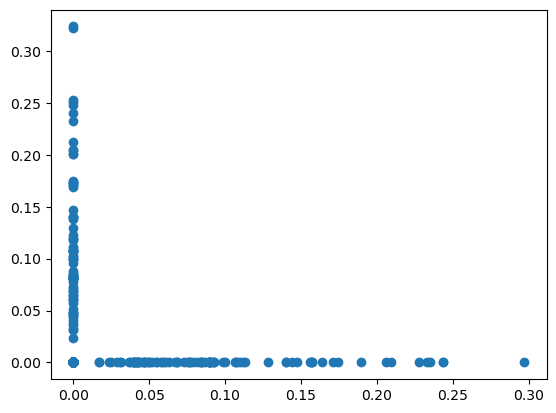

In [65]:
plt.scatter(train_features.iloc[:,10],train_features.iloc[:,11])

## Modeling using mini batch Kmeans:

In [66]:
# Initialize Mini-Batch K-Means
num_clusters = 2 # Number of clusters you want to create
batch_size = 250  # Batch size for updating cluster centers
kmeans = MiniBatchKMeans(n_clusters=num_clusters,init='k-means++', batch_size=batch_size, random_state=42, n_init='auto', reassignment_ratio=0.009)

# Fit the model to your selected features
kmeans.fit(train_features)

# Predict cluster assignments for the data points
cluster_assignments = kmeans.predict(train_features)

# Calculate silhouette score (a measure of cluster quality)
silhouette_avg = silhouette_score(train_features, cluster_assignments)
print("Silhouette Score:", silhouette_avg)



Silhouette Score: 0.009475422174206487


## Confusion Matrix and precision for each label:

In [67]:
y=df['Label']
print(confusion_matrix(y,cluster_assignments))
print("Precision : ", precision_score(y,cluster_assignments,average=None))

[[7988  412]
 [ 556 4197]]
Precision :  [0.93492509 0.91060968]


## Modeling using Kmodes:

In [ ]:
'''# Initialize KModes
num_clusters = 2  # Number of clusters you want to create
km = KModes(n_clusters=num_clusters, init='Huang', n_init=5, verbose=1)

# Fit the model to your categorical data
clusters = km.fit_predict(train_features)'''



In [ ]:
'''# Calculate silhouette score (a measure of cluster quality)
silhouette_avg = silhouette_score(train_features, clusters)
print("Silhouette Score:", silhouette_avg)'''

## Confusion Matrix and precision for each label: 

In [ ]:
'''y=df['Label']
print(confusion_matrix(y,clusters))
print("Precision : ", precision_score(y,clusters,average=None))'''

In [68]:
test_id=test_data['id']


In [69]:
cluster_test = kmeans.predict(test_features)

In [70]:
output = pd.DataFrame({'id': test_id, 'Label': cluster_test})
output.to_csv('Sample_Submition.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
